In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in 1/4, 1/8, or 1/16 degree NW2 data:

In [38]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20; factor = (72/86400) #1/4 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.
#run=26; factor = (192/86400) #1/8 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.
run=28; factor = (540/86400) #1/16 degree NeverWorld2 setup,factor is for the e^2 diagnostic which has an error associated with it.
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
init=xr.open_dataset('run%i/MOM_IC.nc'% (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(fs)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
## For reading in the 1/32 degree NW2 data:

In [33]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
init=xr.open_dataset('run33/MOM_IC.nc', decode_times=False)
av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [39]:
#Read in various grid variables from the static file and forcing:
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
depthmat = np.tile(depth,[100,15,1,1])
print(depthmat.shape)
area_t=fs['area_t']

xh = fs.xh.values
yh = fs.yh.values

interface_ref=os['H0'].values; interface_ref=interface_ref[-1,:-1]
interface_ref_mat=np.transpose(np.tile(interface_ref,[len(yh),len(xh),100,1]),[2,3,0,1])
print(interface_ref_mat.shape)


Layer = np.array(os['Layer']);
drho=np.zeros(15);
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.
drhomat=np.transpose(np.tile(drho,[len(yh),len(xh),1]),[2,0,1])

(100, 15, 2240, 960)
(100, 15, 2240, 960)
[1.0226e+03 2.1000e-01 3.9000e-01 5.4000e-01 5.8000e-01 5.8000e-01
 5.7000e-01 5.3000e-01 4.8000e-01 4.2000e-01 3.7000e-01 3.1000e-01
 2.4000e-01 1.7000e-01 1.1000e-01]


In [40]:
h = np.array(av['h'][:,:,:,:]); h[np.isnan(h)]=0.0
correction  = (interface_ref_mat-depthmat); #if >0 this means h_ref is deeper than topography, we need correction!
correction[correction<0]=0.0 #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = np.zeros(h.shape);
for t in range (0,100):
    for i in range(0,len(Layer)):
        interface[t,i,:,:]=((np.nansum(h[t,i:,:,:],axis=0))-depthmat[t,i,:,:])
#interface is negative down, interface_ref_mat is positive down
    #print(t)

interface_ref_HIC = interface_ref_mat- correction
eta_mean=np.nanmean((interface+interface_ref_HIC),axis=0)
eta_eddy=(interface+interface_ref_HIC)- eta_mean;

eta2_mean = eta_mean**2.
eta2_eddy = np.nanmean(eta_eddy**2.,axis=0)
print(eta2_mean.shape,eta2_eddy.shape)

APE_mean=np.zeros(eta2_mean.shape);
APE_eddy=np.zeros(eta2_eddy.shape);

for i in range(0,len(interface_ref_mat[0,0,:,0])): #looping over y
    for j in range(0,len(interface_ref_mat[0,0,0,:])): #looping over x
        APE_mean[:,i,j] = 0.5*9.81*drhomat[:,i,j]*eta2_mean[:,i,j]/(1022.6*depthmat[0,:,i,j])
        APE_eddy[:,i,j] = 0.5*9.81*drhomat[:,i,j]*eta2_eddy[:,i,j]/(1022.6*depthmat[0,:,i,j])
APE_mean  =np.nansum(APE_mean,axis=0)#*area_t
APE_eddy  =np.nansum(APE_eddy,axis=0)#*area_t

print('done')

(15, 2240, 960) (15, 2240, 960)
done


In [41]:
np.nanmean(APE_mean)

0.5959860202989132

In [42]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS

h  = np.nanmean(np.array(av['h'][:,:,:,:]),axis=0);
print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
ubar=np.nanmean(u,axis=0)
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
vbar=np.nanmean(v,axis=0)
h[np.isnan(h)]=0.0
uprime=np.zeros(u.shape); vprime=np.zeros(v.shape)
for it in range (0,len(u[:,0,0,0])):
    uprime[it,:,:,:]=u[it,:,:,:]-ubar
    vprime[it,:,:,:]=v[it,:,:,:]-vbar

print(uprime.shape)


done 0
(100, 15, 2240, 960)


In [43]:
Depth_3D=np.transpose(np.tile(np.nansum(h,axis=0),[Nlayers,1,1]),(0,1,2))
ubar_TW=ubar*h/Depth_3D; 
ubar_BT=np.tile(np.nansum(ubar_TW,axis=0),[Nlayers,1,1])
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth_3D
vbar_BT=np.tile(np.nansum(vbar_TW,axis=0),[Nlayers,1,1])
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT[0,:,:]**2+ubar_BT[0,:,:]**2) #dim y,x
KE_mean_BC=np.nansum(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth_3D,axis=0) #dim y,x


KE_eddy_BT_temp=np.zeros(u[:,0,:,:].shape); 
KE_eddy_BC_temp=np.zeros(u[:,0,:,:].shape)

for it in range (0,len(u[:,0,0,0])):
    uprime_BT=np.tile(np.nansum(uprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    uprime_BC=uprime[it,:,:,:]-uprime_BT
    vprime_BT=np.tile(np.nansum(vprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    vprime_BC=vprime[it,:,:,:]-vprime_BT
    
    KE_eddy_BT_temp[it,:,:]=0.5*(vprime_BT[0,:,:]**2+uprime_BT[0,:,:]**2)
    KE_eddy_BC_temp[it,:,:]=np.nansum(0.5*(vprime_BC**2+uprime_BC**2)*h/Depth_3D,axis=0)
    #print(it)
    
KE_eddy_BT = np.nanmean(KE_eddy_BT_temp,axis=0)
KE_eddy_BC = np.nanmean(KE_eddy_BC_temp,axis=0)

# #Total kinetic energy:
KE_BT_tot=(KE_eddy_BT+KE_mean_BT)
KE_BC_tot=(KE_eddy_BC+KE_mean_BC)
KE_tot=(KE_BT_tot+KE_BC_tot)

#KE_eddy = KE_eddy_BT+ KE_eddy_BC
#KE_mean = KE_mean_BT+ KE_eddy_BC
print('done')

done


In [44]:
yh_00625 = yh;
APE_mean_00625 = APE_mean
APE_eddy_00625 = APE_eddy

KE_mean_BT_00625  = KE_mean_BT
KE_mean_BC_00625  = KE_mean_BC
KE_eddy_BT_00625  = KE_eddy_BT
KE_eddy_BC_00625  = KE_eddy_BC

print('done')

done


## Be careful here that nanmean(x/y) DOES NOT EQUAL nanmean(x)/nanmean(y)

Text(0.5, 1.0, 'Zonally averaged APE/KE')

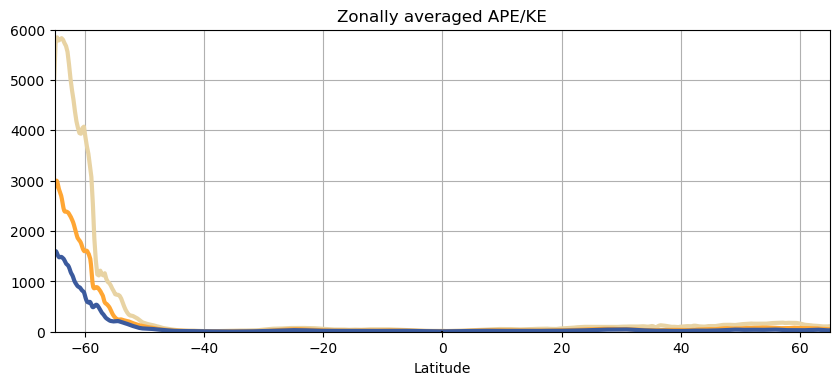

In [76]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_mean_025+APE_eddy_025,axis=1)/np.nanmean(KE_mean_BT_025+KE_mean_BC_025+KE_eddy_BT_025+KE_eddy_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_mean_0125+APE_eddy_0125,axis=1)/np.nanmean(KE_mean_BT_0125+KE_mean_BC_0125+KE_eddy_BT_0125+KE_eddy_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_mean_00625+APE_eddy_00625,axis=1)/np.nanmean(KE_mean_BT_00625+KE_mean_BC_00625+KE_eddy_BT_00625+KE_eddy_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

#plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,6000);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Zonally averaged APE/KE')

Text(0.5, 1.0, 'Zonally averaged mean APE/KE')

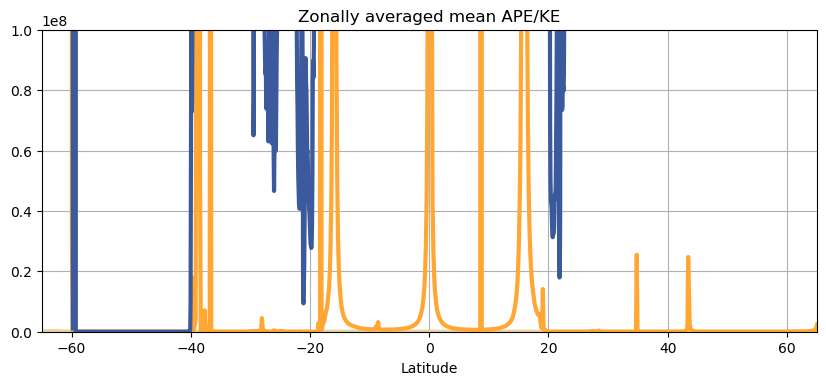

In [66]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_mean_025/(KE_mean_BT_025+KE_mean_BC_025),axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_mean_0125/(KE_mean_BT_0125+KE_mean_BC_0125),axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_mean_00625/(KE_mean_BT_00625+KE_mean_BC_00625),axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

#plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,1e8);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Zonally averaged mean APE/KE')

In [67]:
APE_mean_025.shape

(560, 240)

Text(0.5, 1.0, 'Zonally averaged eddy APE/eddy KE')

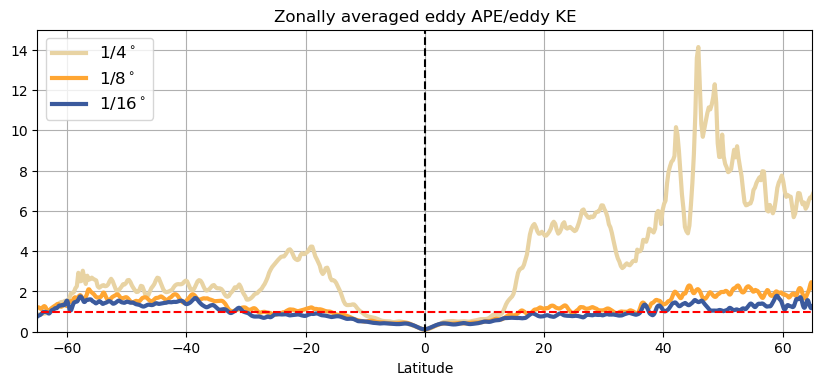

In [82]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_eddy_025,axis=1)/np.nanmean(KE_eddy_BT_025+KE_eddy_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_eddy_0125,axis=1)/np.nanmean(KE_eddy_BT_0125+KE_eddy_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_eddy_00625,axis=1)/np.nanmean(KE_eddy_BT_00625+KE_eddy_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],fontsize=12)
plt.plot([0, 0],[0, 10000],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(-65,65)

plt.ylim(0,15);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Zonally averaged eddy APE/eddy KE')

Text(0.5, 1.0, 'Zonally averaged eddy APE/mean APE')

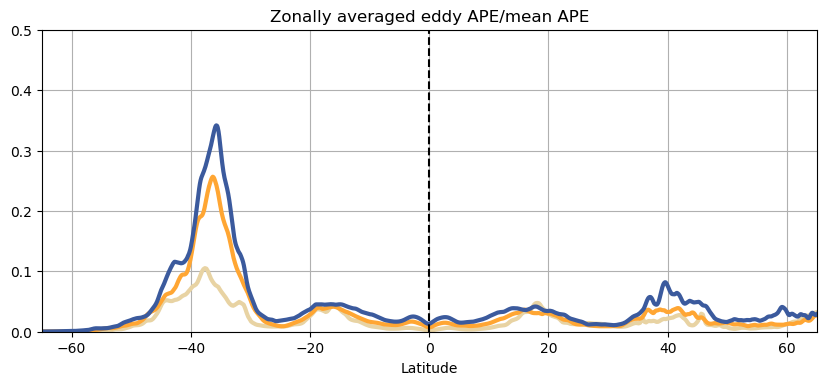

In [78]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_eddy_025,axis=1)/np.nanmean(APE_mean_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_eddy_0125,axis=1)/np.nanmean(APE_mean_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_eddy_00625,axis=1)/np.nanmean(APE_mean_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

#plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,.5);
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('Zonally averaged eddy APE/mean APE')

Text(0.5, 1.0, 'Zonally averaged eddy KE/mean KE')

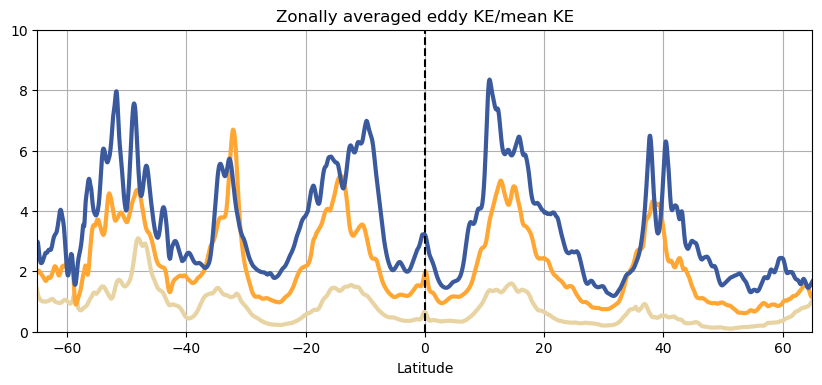

In [47]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(KE_eddy_BT_025+KE_eddy_BC_025,axis=1)/np.nanmean(KE_mean_BT_025+KE_mean_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(KE_eddy_BT_0125+KE_eddy_BC_0125,axis=1)/np.nanmean(KE_mean_BT_0125+KE_mean_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(KE_eddy_BT_00625+KE_eddy_BC_00625,axis=1)/np.nanmean(KE_mean_BT_00625+KE_mean_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

#plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,10);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Zonally averaged eddy KE/mean KE')



Text(0.5, 1.0, 'Zonally averaged eddy APE/total KE')

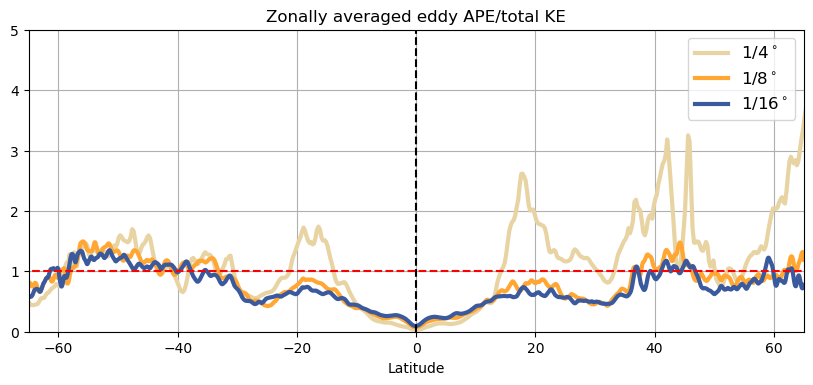

In [83]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_eddy_025,axis=1)/np.nanmean(KE_eddy_BT_025+KE_eddy_BC_025+KE_mean_BT_025+KE_mean_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_eddy_0125,axis=1)/np.nanmean(KE_eddy_BT_0125+KE_eddy_BC_0125+KE_mean_BT_0125+KE_mean_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_eddy_00625,axis=1)/np.nanmean(KE_eddy_BT_00625+KE_eddy_BC_00625+KE_mean_BT_00625+KE_mean_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(-65,65)

plt.ylim(0,5);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Zonally averaged eddy APE/total KE')

Text(0.5, 1.0, 'Eddy APE values [J/kg]')

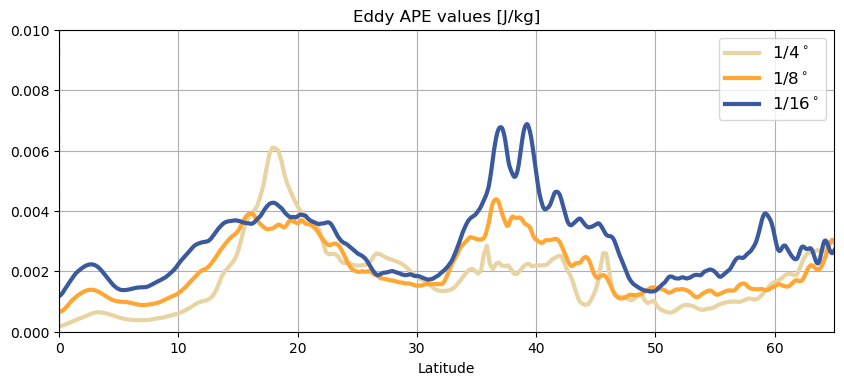

In [110]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_eddy_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_eddy_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_eddy_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(0,65)

plt.ylim(0,.01);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Eddy APE values [J/kg]')

Text(0.5, 1.0, 'Total KE values [J/kg]')

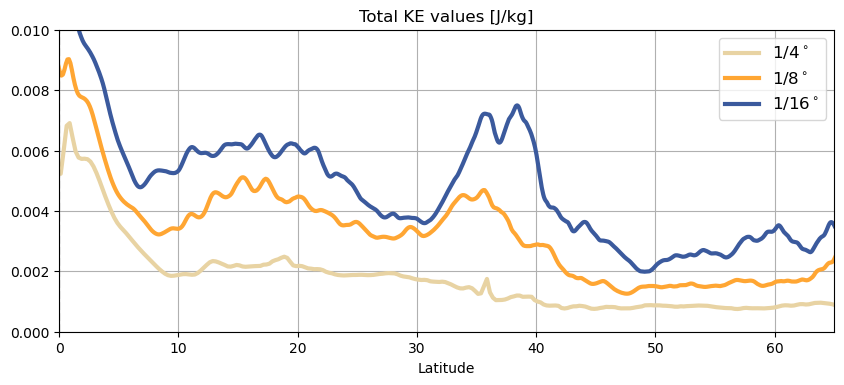

In [113]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(KE_eddy_BT_025+KE_eddy_BC_025+KE_mean_BT_025+KE_mean_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(KE_eddy_BT_0125+KE_eddy_BC_0125+KE_mean_BT_0125+KE_mean_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(KE_eddy_BT_00625+KE_eddy_BC_00625+KE_mean_BT_00625+KE_mean_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(0,65)

plt.ylim(0,.01);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Total KE values [J/kg]')

Text(0.5, 1.0, 'Mean KE values [J/kg]')

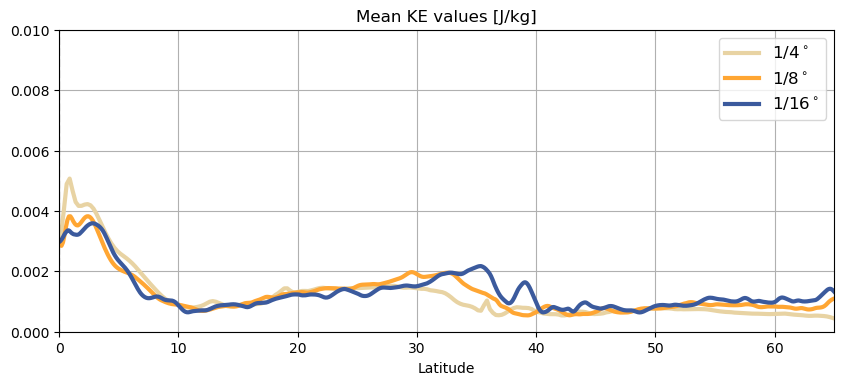

In [114]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(KE_mean_BT_025+KE_mean_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(KE_mean_BT_0125+KE_mean_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(KE_mean_BT_00625+KE_mean_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(0,65)

plt.ylim(0,.01);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Mean KE values [J/kg]')

Text(0.5, 1.0, 'Eddy KE values [J/kg]')

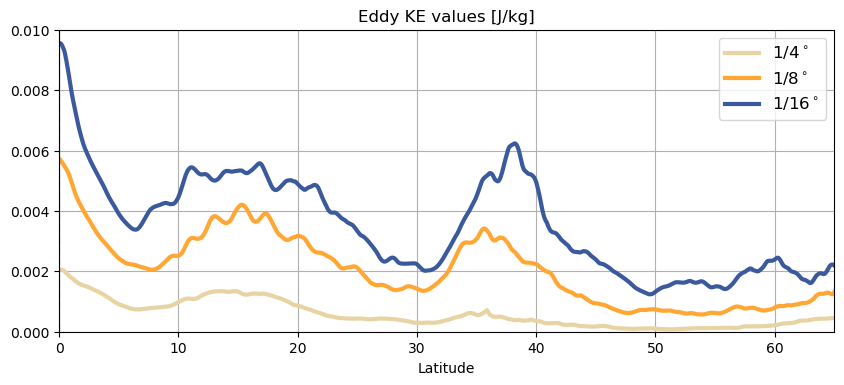

In [116]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(KE_eddy_BT_025+KE_eddy_BC_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(KE_eddy_BT_0125+KE_eddy_BC_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(KE_eddy_BT_00625+KE_eddy_BC_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_m003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(0,65)

plt.ylim(0,.01);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('Eddy KE values [J/kg]')

### Verifying to make sure the BC/BT KE decomposition looks the same as in the other analyses:

Text(0.5, 1.0, 'BT vs. BC KE 1/4 degree')

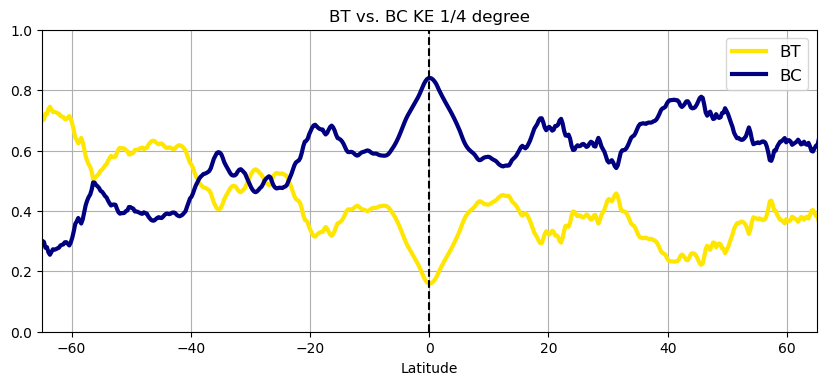

In [57]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
KE_total_025=KE_eddy_BT_025+KE_mean_BT_025+KE_eddy_BC_025+KE_mean_BC_025
plt.plot(yh_025,np.nanmean((KE_eddy_BT_025+KE_mean_BT_025)/KE_total_025,axis=1),'-',c=[1.,.9,0],linewidth=3)
plt.plot(yh_025,np.nanmean((KE_eddy_BC_025+KE_mean_BC_025)/KE_total_025,axis=1),'-',c=[0.,0.,.5],linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['BT', 'BC'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
#plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(-65,65)

plt.ylim(0,1);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('BT vs. BC KE 1/4 degree')

Text(0.5, 1.0, 'BT vs. BC KE 1/4 degree')

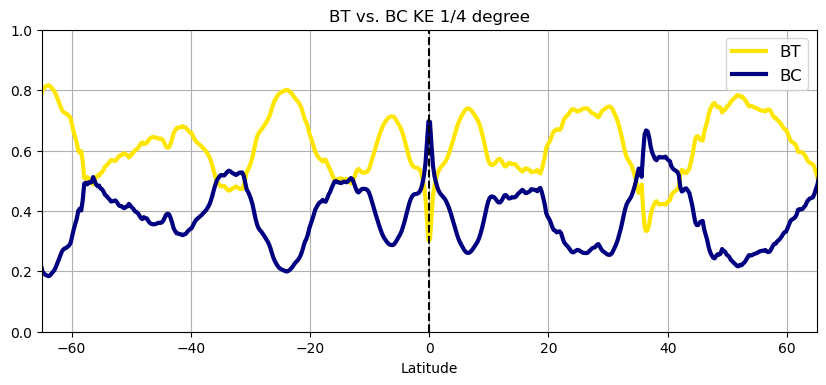

In [61]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
KE_total_025=KE_eddy_BT_025+KE_mean_BT_025+KE_eddy_BC_025+KE_mean_BC_025
KE_eddy_BT_025[KE_eddy_BT_025==0]=np.nan; KE_eddy_BC_025[KE_eddy_BC_025==0]=np.nan;
KE_mean_BT_025[KE_mean_BT_025==0]=np.nan; KE_mean_BC_025[KE_mean_BC_025==0]=np.nan;
KE_total_025[KE_total_025==0]=np.nan

plt.plot(yh_025,np.nanmean((KE_eddy_BT_025+KE_mean_BT_025),axis=1)/np.nanmean(KE_total_025,axis=1),'-',c=[1.,.9,0],linewidth=3)
plt.plot(yh_025,np.nanmean((KE_eddy_BC_025+KE_mean_BC_025),axis=1)/np.nanmean(KE_total_025,axis=1),'-',c=[0.,0.,.5],linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['BT', 'BC'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
#plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(-65,65)

plt.ylim(0,1);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('BT vs. BC KE 1/4 degree')

Text(0.5, 1.0, 'BT vs. BC KE 1/8 degree')

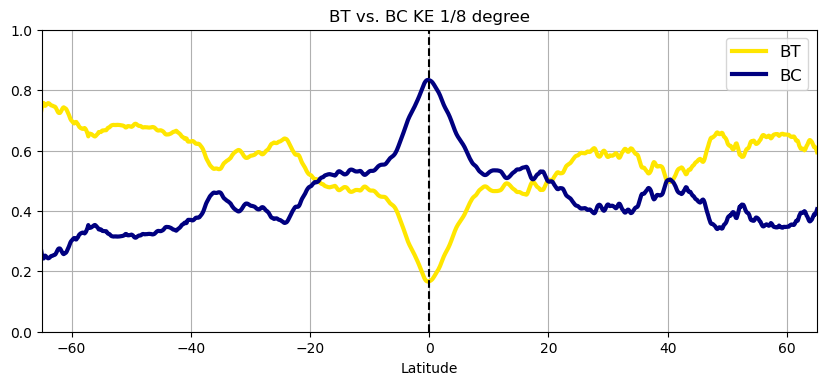

In [37]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
KE_total_0125=KE_eddy_BT_0125+KE_mean_BT_0125+KE_eddy_BC_0125+KE_mean_BC_0125
plt.plot(yh_0125,np.nanmean((KE_eddy_BT_0125+KE_mean_BT_0125)/KE_total_0125,axis=1),'-',c=[1.,.9,0],linewidth=3)
plt.plot(yh_0125,np.nanmean((KE_eddy_BC_0125+KE_mean_BC_0125)/KE_total_0125,axis=1),'-',c=[0.,0.,.5],linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['BT', 'BC'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 100],'--',color=[0,0,0])
#plt.plot([-70, 70],[1, 1],'--',color=[1,0,0])

plt.xlim(-65,65)

plt.ylim(0,1);
plt.xlabel('Latitude')
#plt.ylabel('APE/KE')
plt.title('BT vs. BC KE 1/8 degree')

In [72]:
a = np.array([3, 5, np.nan, 6])
b = np.array([2, np.nan, 3, 5])


In [73]:
print(np.nanmean(a)/np.nanmean(b))
print(np.nanmean(a/b))


1.4000000000000001
1.35


In [74]:
(3/2+6/5)/2

1.35